### Econ 570: Assignment 2 - Data Generating Processes

$0.$ $Install$ $Package$

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from matplotlib import style
import seaborn as sns
import graphviz as gr

style.use("fivethirtyeight")

### 1. Simulate a DGP where the outcome of interest depends on a randomly assigned treatment and some observed covariates. How does your estimate of the treatment effect parameter compare in the following two cases:

a. You do not control for any covariates

b. You control for all the covariates that affect the outcome

“The standard local polynomial estimator with covariates entering in an additive-separable, linear-in-parameters way and showed that the resulting covariate-adjusted RD estimator remains consistent for the standard RD treatment effect if the covariate adjustment is restricted to be equivalent above and below the cutoff” - Sebastian Calonico, Matias D. Cattaneo, Max H. Farrell, Rocío Titiunik; Regression Discontinuity Designs Using Covariates. The Review of Economics and Statistics 2019; 101 (3): 442–451. doi: https://doi.org/10.1162/rest_a_00760

$1.0.1$ $Generate$ $Data$

$y_i = \beta_0 + \kappa T + \beta_1 X + u_i$

$\kappa$ can be obtained with the following formula

$\kappa = \dfrac{Cov(Y_i, \tilde{T_i})}{Var(\tilde{T_i})}$

where $\tilde{T_i}$ is the residual from a regression of all other covariates 
$X_{1i} + ... + X_{ki}$ on $T_i$. 

(array([  7.,  25.,  76., 165., 231., 207., 156.,  93.,  29.,  11.]),
 array([-1.02323127, -0.12566191,  0.77190745,  1.66947681,  2.56704617,
         3.46461552,  4.36218488,  5.25975424,  6.1573236 ,  7.05489296,
         7.95246232]),
 <BarContainer object of 10 artists>)

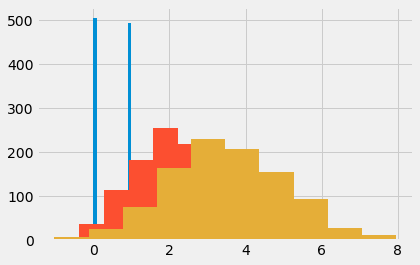

In [2]:
k = 1 # ATE
beta_0 = 1 # intercept
beta_1 = 1 # covariates parameters
n = 1000 # number of trails
p = 0.5  # probability of each trial
T = np.random.binomial(1, p, n)
X = np.random.normal(2,1,n)
e = np.random.normal(0,1,n)
y = beta_0 + k*T + beta_1*X + e
plt.hist(T)
plt.hist(X)
plt.hist(y)



$1.1.1$ $DAG$

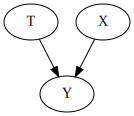

In [3]:
g = gr.Digraph()
g.edge("T", "Y")
g.edge("X", "Y")
g

$1.2.1$ $Monte$ $Carlo$ $Method$

a. You do not control for any covariates

In [4]:
class MC_Simulator():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, beta_0, k, n, sigma):
        """
        beta_0: intercept
        beta_1: covariates parameters
        k: slope
        n: sample size
        p: probability of select for treatment
        sigma: error variance
        y = beta_0 + k*T + beta_1*X + e
        """
        T = np.random.binomial(1, p, n)
        e = np.random.normal(0, 1, n)
        beta_1 = 1
        X = np.random.normal(2,1,n)
        y = np.random.normal(beta_0 + k*T + beta_1*X, 5).astype(int)
        
        return (y,T)
    
    def estimate_ols_params(self,y,T):
        mod = sm.OLS(y,sm.add_constant(T))
        res = mod.fit()
        
        return res.params
    
    def run_mc_simulation(self,beta_0,k,n,sigma):
        beta_0_estimates = []
        k_estimates = []
        bias = []
        RMSE = []
        
        for rep in range(self.n_rep):
            y,T = self.simulate_data(beta_0,k,n,sigma)
            beta_0_hat,k_hat = self.estimate_ols_params(y,T)
            y_hat = beta_0_hat + k_hat * T
            beta_0_estimates = beta_0_estimates + [beta_0_hat]
            k_estimates = k_estimates + [k_hat]
            bias = bias + [np.mean(y[T==1])-np.mean(y[T==0])]
            RMSE = RMSE + [np.sqrt(np.mean((y-y_hat)**2))]
        return beta_0_estimates, k_estimates, bias, RMSE
    
    def summarize_mc_simulation(self,beta_0,k,n,sigma):
        beta_0_estimates, k_estimates, bias, RMSE= self.run_mc_simulation(beta_0,k,n,sigma)
        print(f'Mean beta_0 = {np.mean(beta_0_estimates):.3f} \n')
        print(f'Mean k = {np.mean(k_estimates):.3f} \n')
        print(f'Mean bias = {np.mean(bias):.3f} \n')
        print(f'Mean RMSE = {np.mean(RMSE):.3f} \n') 
            
    def plot_parameter_estimates(self,beta_0,k,n,sigma,alpha):
        beta_0_estimates, k_estimates, bias, RMSE= self.run_mc_simulation(beta_0,k,n,sigma)
        
        fig = plt.figure()
        plt.hist(beta_0_estimates, label = 'Beta_0', alpha = alpha)
        plt.hist(k_estimates, label = 'k', alpha = alpha)
        plt.legend()

In [5]:
mcSim = MC_Simulator(100)
mcSim.summarize_mc_simulation(0,1,100,0.1)

Mean beta_0 = 1.814 

Mean k = 0.995 

Mean bias = 0.995 

Mean RMSE = 4.701 



In [6]:
mcSim = MC_Simulator(1000)
mcSim.summarize_mc_simulation(0,1,1000,0.1)

Mean beta_0 = 1.848 

Mean k = 0.925 

Mean bias = 0.925 

Mean RMSE = 4.764 



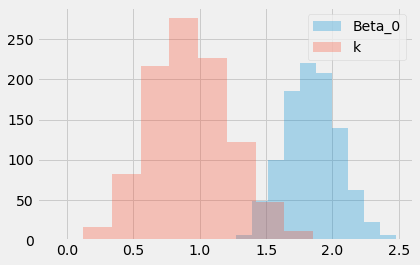

In [7]:
mcSim.plot_parameter_estimates(0,1,1000,0.1,.3)

b. You control for all the covariates that affect the outcome

In [8]:
class MC_Simulator():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, beta_0, k, n, sigma):
        """
        beta_0: intercept
        beta_1: covariates parameters
        k: slope
        n: sample size
        p: probability of select for treatment
        sigma: error variance
        y = beta_0 + k*T + beta_1*X + e
        """
        T = np.random.binomial(1, p, n)
        e = np.random.normal(0, 1, n)
        beta_1 = 1
        X = np.random.normal(2,1,n)
        y = np.random.normal(beta_0 + k*T + beta_1*X, 5).astype(int)
        
        return (y,T)
    
    def estimate_ols_params(self,y,T):
        mod = sm.OLS(y,sm.add_constant(T),sm.add_constant(X))
        res = mod.fit()
        
        return res.params
    
    def run_mc_simulation(self,beta_0,k,n,sigma):
        beta_0_estimates = []
        k_estimates = []
        bias = []
        RMSE = []
        
        for rep in range(self.n_rep):
            y,T = self.simulate_data(beta_0,k,n,sigma)
            beta_0_hat,k_hat = self.estimate_ols_params(y,T)
            y_hat = beta_0_hat + k_hat * T
            beta_0_estimates = beta_0_estimates + [beta_0_hat]
            k_estimates = k_estimates + [k_hat]
            bias = bias + [np.mean(y[T==1])-np.mean(y[T==0])]
            RMSE = RMSE + [np.sqrt(np.mean((y-y_hat)**2))]
        return beta_0_estimates, k_estimates, bias, RMSE
    
    def summarize_mc_simulation(self,beta_0,k,n,sigma):
        beta_0_estimates, k_estimates, bias, RMSE= self.run_mc_simulation(beta_0,k,n,sigma)
        print(f'Mean beta_0 = {np.mean(beta_0_estimates):.3f} \n')
        print(f'Mean k = {np.mean(k_estimates):.3f} \n')
        print(f'Mean bias = {np.mean(bias):.3f} \n')
        print(f'Mean RMSE = {np.mean(RMSE):.3f} \n') 
            
    def plot_parameter_estimates(self,beta_0,k,n,sigma,alpha):
        beta_0_estimates, k_estimates, bias, RMSE= self.run_mc_simulation(beta_0,k,n,sigma)
        
        fig = plt.figure()
        plt.hist(beta_0_estimates, label = 'Beta_0', alpha = alpha)
        plt.hist(k_estimates, label = 'k', alpha = alpha)
        plt.legend()

In [9]:
mcSim = MC_Simulator(100)
mcSim.summarize_mc_simulation(0,1,100,0.1)

Mean beta_0 = 1.850 

Mean k = 0.879 

Mean bias = 0.879 

Mean RMSE = 4.664 



In [10]:
mcSim = MC_Simulator(1000)
mcSim.summarize_mc_simulation(0,1,100,0.1)

Mean beta_0 = 1.821 

Mean k = 0.919 

Mean bias = 0.919 

Mean RMSE = 4.687 



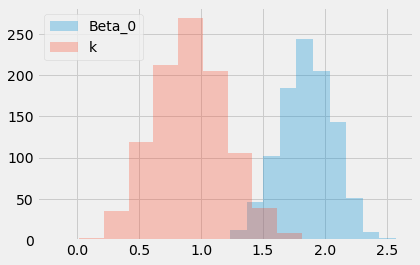

In [11]:
mcSim.plot_parameter_estimates(0,1,1000,0.1,.3)

$1.3.1$ Example

An engineer wants to study the level of corrosion on four types of iron beams. The engineer exposes each beam to a liquid treatment to accelerate corrosion, but cannot control the temperature of the liquid. Temperature is a covariate that should be considered in the model.And Therefore we should consider to use Temperature as a cov. in the regession.

### 2. Simulate a DGP with a confounder (common cause)

a. You fail to control for the confounder

b. You do control for the confounder

"Confounders are factors that confound the relationship between the trial drug and outcome. Some trials may permit adjunctive drugs during the trial or adjunctive treatments such as psychotherapy. These are confounders because results may be attributable to the adjuncts rather than to the drug being tested. As an example, trials of pain medications often ignore participants’ use of nondrug pain relievers such as splints, creams, massage, hot baths, and chiropractors’ manipulations. Response to these extra trial treatments may significantly confound the results of the trial." - Mary V. Seeman, ... Nigel H. Greig, in Handbook of Clinical Neurology, 2019

$2.0.1$ $Generate$ $Data$

Using more general terms like  for the treatment and  for the confounders, here is want we want:

$Y_i = \beta_0 + \kappa \ T_i + \pmb{\beta}W_i + u_i$

However, we don’t have data on $W$, so all we can run is:

$Y_i = \beta_0 + \kappa\ T_i + v_i$


$v_i = \pmb{\beta}W_i + u_i$


(array([  5.,  21.,  81., 170., 146., 229., 195.,  96.,  42.,  15.]),
 array([-3. , -0.2,  2.6,  5.4,  8.2, 11. , 13.8, 16.6, 19.4, 22.2, 25. ]),
 <BarContainer object of 10 artists>)

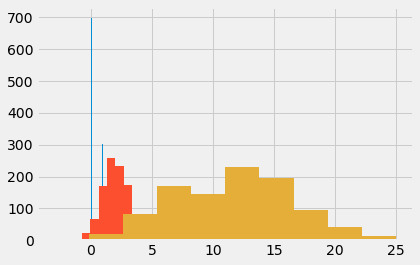

In [12]:
n = 1000 # number
k = 1 # ATE
beta_0 = 10 
beta_1 = 1
# generate covariate
X = np.random.normal(2,1,n)
# generate treatment
T = np.random.binomial(1, 1/(1+X**2), n)
# generate outcome
y = np.random.normal(beta_0 + k*T + beta_1*X, 5).astype(int)

plt.hist(T)
plt.hist(X)
plt.hist(y)

$2.1.1$ $DAG$

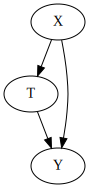

In [13]:
g = gr.Digraph()
g.edge("X", "T")
g.edge("T", "Y")
g.edge("X", "Y")
g

$2.2.1$ $Monte$ $Carlo$ $Method$

a. You fail to control for the confounder

In [14]:
class MC_Simulator():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, beta_0, k, n, sigma):
        """
        beta_0: intercept
        beta_1: covariates parameters
        k: slope
        n: sample size
        p: probability of select for treatment
        sigma: error variance
        y = beta_0 + k*T + beta_1*X + e
        """
        T = np.random.binomial(1, p, n)
        e = np.random.normal(0, 1, n)
        beta_1 = 1
        X = np.random.normal(2,1,n)
        T = np.random.binomial(1, 1/(1+X**2), n)
        y = np.random.normal(beta_0 + k*T + beta_1*X, 5).astype(int)
        
        return (y,T)
    
    def estimate_ols_params(self,y,T):
        mod = sm.OLS(y,sm.add_constant(T))
        res = mod.fit()
        
        return res.params
    
    def run_mc_simulation(self,beta_0,k,n,sigma):
        beta_0_estimates = []
        k_estimates = []
        bias = []
        RMSE = []
        
        for rep in range(self.n_rep):
            y,T = self.simulate_data(beta_0,k,n,sigma)
            beta_0_hat,k_hat = self.estimate_ols_params(y,T)
            y_hat = beta_0_hat + k_hat * T
            beta_0_estimates = beta_0_estimates + [beta_0_hat]
            k_estimates = k_estimates + [k_hat]
            bias = bias + [np.mean(y[T==1])-np.mean(y[T==0])]
            RMSE = RMSE + [np.sqrt(np.mean((y-y_hat)**2))]
        return beta_0_estimates, k_estimates, bias, RMSE
    
    def summarize_mc_simulation(self,beta_0,k,n,sigma):
        beta_0_estimates, k_estimates, bias, RMSE= self.run_mc_simulation(beta_0,k,n,sigma)
        print(f'Mean beta_0 = {np.mean(beta_0_estimates):.3f} \n')
        print(f'Mean k = {np.mean(k_estimates):.3f} \n')
        print(f'Mean bias = {np.mean(bias):.3f} \n')
        print(f'Mean RMSE = {np.mean(RMSE):.3f} \n') 
            
    def plot_parameter_estimates(self,beta_0,k,n,sigma,alpha):
        beta_0_estimates, k_estimates, bias, RMSE= self.run_mc_simulation(beta_0,k,n,sigma)
        
        fig = plt.figure()
        plt.hist(beta_0_estimates, label = 'Beta_0', alpha = alpha)
        plt.hist(k_estimates, label = 'k', alpha = alpha)
        plt.legend()

In [15]:
mcSim = MC_Simulator(100)
mcSim.summarize_mc_simulation(0,1,100,0.1)

Mean beta_0 = 2.145 

Mean k = -0.017 

Mean bias = -0.017 

Mean RMSE = 4.682 



In [16]:
mcSim = MC_Simulator(1000)
mcSim.summarize_mc_simulation(0,1,100,0.1)

Mean beta_0 = 2.103 

Mean k = -0.005 

Mean bias = -0.005 

Mean RMSE = 4.671 



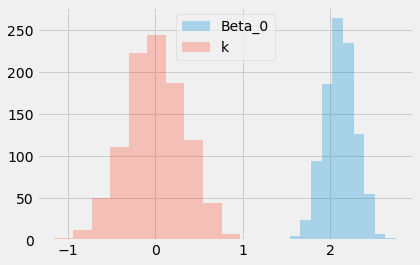

In [17]:
mcSim.plot_parameter_estimates(0,1,1000,0.1,.3)

b. You do control for the confounder

In [18]:
class MC_Simulator():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, beta_0, k, n, sigma):
        """
        beta_0: intercept
        beta_1: covariates parameters
        k: slope
        n: sample size
        p: probability of select for treatment
        sigma: error variance
        y = beta_0 + k*T + beta_1*X + e
        """
        T = np.random.binomial(1, p, n)
        e = np.random.normal(0, 1, n)
        beta_1 = 1
        X = np.random.normal(2,1,n)
        T = np.random.binomial(1, 1/(1+X**2), n)
        y = np.random.normal(beta_0 + k*T + beta_1*X, 5).astype(int)
        
        return (y,T)
    
    def estimate_ols_params(self,y,T):
        mod = sm.OLS(y,sm.add_constant(T),sm.add_constant(X))
        res = mod.fit()
        
        return res.params
    
    def run_mc_simulation(self,beta_0,k,n,sigma):
        beta_0_estimates = []
        k_estimates = []
        bias = []
        RMSE = []
        
        for rep in range(self.n_rep):
            y,T = self.simulate_data(beta_0,k,n,sigma)
            beta_0_hat,k_hat = self.estimate_ols_params(y,T)
            y_hat = beta_0_hat + k_hat * T
            beta_0_estimates = beta_0_estimates + [beta_0_hat]
            k_estimates = k_estimates + [k_hat]
            bias = bias + [np.mean(y[T==1])-np.mean(y[T==0])]
            RMSE = RMSE + [np.sqrt(np.mean((y-y_hat)**2))]
        return beta_0_estimates, k_estimates, bias, RMSE
    
    def summarize_mc_simulation(self,beta_0,k,n,sigma):
        beta_0_estimates, k_estimates, bias, RMSE= self.run_mc_simulation(beta_0,k,n,sigma)
        print(f'Mean beta_0 = {np.mean(beta_0_estimates):.3f} \n')
        print(f'Mean k = {np.mean(k_estimates):.3f} \n')
        print(f'Mean bias = {np.mean(bias):.3f} \n')
        print(f'Mean RMSE = {np.mean(RMSE):.3f} \n') 
            
    def plot_parameter_estimates(self,beta_0,k,n,sigma,alpha):
        beta_0_estimates, k_estimates, bias, RMSE= self.run_mc_simulation(beta_0,k,n,sigma)
        
        fig = plt.figure()
        plt.hist(beta_0_estimates, label = 'Beta_0', alpha = alpha)
        plt.hist(k_estimates, label = 'k', alpha = alpha)
        plt.legend()

In [19]:
mcSim = MC_Simulator(100)
mcSim.summarize_mc_simulation(0,-1,100,0.1)

Mean beta_0 = 2.059 

Mean k = -1.774 

Mean bias = -1.774 

Mean RMSE = 4.675 



In [20]:
mcSim = MC_Simulator(10000)
mcSim.summarize_mc_simulation(0,-1,100,0.1)

Mean beta_0 = 2.111 

Mean k = -1.839 

Mean bias = -1.839 

Mean RMSE = 4.663 



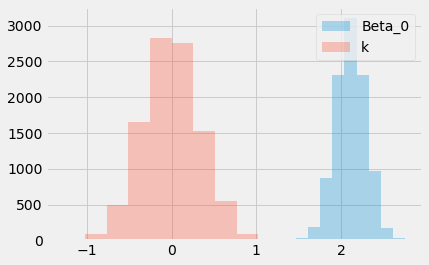

In [21]:
mcSim.plot_parameter_estimates(0,1,1000,0.1,.3)

$2.3.1$ Example

Confounders are factors other than the exposure/intervention that may affect the outcome of interest and that can be related to exposure/intervention. For example, in a study of the effects of caffeine on pregnancy outcomes, smoking might be a confounder if women who drank coffee were more likely to be smokers than were women who did not drink coffee. To see whether confounding might be an issue, readers should look for data on the baseline characteristics of the drug and comparison groups and check that they are similarly distributed between the treatment and the comparison groups, which will often be the case in at least moderately sized randomized, controlled trials.

### 3. Simulate a DGP with selection bias into the treatment (variable in between the path from the treatment to the outcome)

a. You control for the variable in between the path from cause to effect

b. You do not control for the variable in between the path from cause to effect

"Selection bias occurs when the study population is not representative of the target population so that the measure of risks/benefits does not accurately represent the target population to which conclusions are being extended. Selection bias could occur because of an error in the procedure used to select subjects or if there are other reasons that could explain why some participants would want to participate in the study and not others, or if some participants are more likely to be selected than others"-Sabrina Nour, Gilles Plourde, in Pharmacoepidemiology and Pharmacovigilance, 2019

$3.0.1$ $Generate$ $Data$

(array([ 12.,   0., 362.,   0., 318.,   0., 226.,   0.,  78.,   4.]),
 array([-1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ]),
 <BarContainer object of 10 artists>)

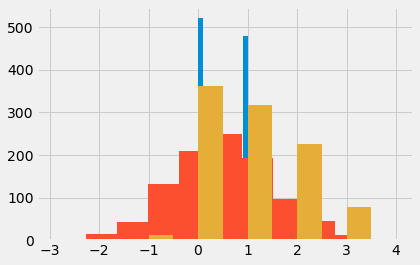

In [22]:
n = 1000 # number
k = 1 # ATE
beta_0 = 1 
T = np.random.binomial(1, 0.5, n) # generate treatment
y = np.random.normal(beta_0 + k*T, 1).astype(int) # generate outcome
X = np.random.normal(np.mean(T)*np.mean(y),1,n) # generate covariate
plt.hist(T)
plt.hist(X)
plt.hist(y)

$3.1.1$ $DAG$

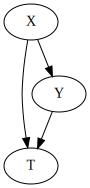

In [23]:
g = gr.Digraph()
g.edge("X", "T")
g.edge("Y", "T")
g.edge("X", "Y")
g

$3.2.1$ $Monte$ $Carlo$ $Method$

a. You control for the variable in between the path from cause to effect

In [24]:
class MC_Simulator():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, beta_0, k, n, sigma):
        """
        beta_0: intercept
        beta_1: covariates parameters
        k: slope
        n: sample size
        p: probability of select for treatment
        sigma: error variance
        y = beta_0 + k*T + beta_1*X + e
        """
        T = np.random.binomial(1, p, n)
        e = np.random.normal(0, 1, n)
        beta_1 = 1
        T = np.random.binomial(1, 0.5, n) 
        y = np.random.normal(beta_0 + k*T, 1).astype(int) 
        X = np.random.normal(T*y,1,n) 
        
        return (y,T)
    
    def estimate_ols_params(self,y,T):
        mod = sm.OLS(y,sm.add_constant(T))
        res = mod.fit()
        
        return res.params
    
    def run_mc_simulation(self,beta_0,k,n,sigma):
        beta_0_estimates = []
        k_estimates = []
        bias = []
        RMSE = []
        
        for rep in range(self.n_rep):
            y,T = self.simulate_data(beta_0,k,n,sigma)
            beta_0_hat,k_hat = self.estimate_ols_params(y,T)
            y_hat = beta_0_hat + k_hat * T
            beta_0_estimates = beta_0_estimates + [beta_0_hat]
            k_estimates = k_estimates + [k_hat]
            bias = bias + [np.mean(y[T==1])-np.mean(y[T==0])]
            RMSE = RMSE + [np.sqrt(np.mean((y-y_hat)**2))]
        return beta_0_estimates, k_estimates, bias, RMSE
    
    def summarize_mc_simulation(self,beta_0,k,n,sigma):
        beta_0_estimates, k_estimates, bias, RMSE= self.run_mc_simulation(beta_0,k,n,sigma)
        print(f'Mean beta_0 = {np.mean(beta_0_estimates):.3f} \n')
        print(f'Mean k = {np.mean(k_estimates):.3f} \n')
        print(f'Mean bias = {np.mean(bias):.3f} \n')
        print(f'Mean RMSE = {np.mean(RMSE):.3f} \n') 
            
    def plot_parameter_estimates(self,beta_0,k,n,sigma,alpha):
        beta_0_estimates, k_estimates, bias, RMSE= self.run_mc_simulation(beta_0,k,n,sigma)
        
        fig = plt.figure()
        plt.hist(beta_0_estimates, label = 'Beta_0', alpha = alpha)
        plt.hist(k_estimates, label = 'k', alpha = alpha)
        plt.legend()

In [25]:
mcSim = MC_Simulator(100)
mcSim.summarize_mc_simulation(0,1,100,0.1)

Mean beta_0 = -0.011 

Mean k = 0.667 

Mean bias = 0.667 

Mean RMSE = 0.751 



In [26]:
mcSim = MC_Simulator(1000)
mcSim.summarize_mc_simulation(0,1,100,0.1)

Mean beta_0 = -0.002 

Mean k = 0.661 

Mean bias = 0.661 

Mean RMSE = 0.752 



b. You do not control for the variable in between the path from cause to effect

In [27]:
class MC_Simulator():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, beta_0, k, n, sigma):
        """
        beta_0: intercept
        beta_1: covariates parameters
        k: slope
        n: sample size
        p: probability of select for treatment
        sigma: error variance
        y = beta_0 + k*T + beta_1*X + e
        """
        T = np.random.binomial(1, p, n)
        e = np.random.normal(0, 1, n)
        beta_1 = 1
        T = np.random.binomial(1, 0.5, n) 
        y = np.random.normal(beta_0 + k*T, 1).astype(int) 
        X = np.random.normal(beta_1*T*y,1,n) 
        
        return (y,T)
    
    def estimate_ols_params(self,y,T):
        mod = sm.OLS(y,sm.add_constant(T),sm.add_constant(X))
        res = mod.fit()
        
        return res.params
    
    def run_mc_simulation(self,beta_0,k,n,sigma):
        beta_0_estimates = []
        k_estimates = []
        bias = []
        RMSE = []
        
        for rep in range(self.n_rep):
            y,T = self.simulate_data(beta_0,k,n,sigma)
            beta_0_hat,k_hat = self.estimate_ols_params(y,T)
            y_hat = beta_0_hat + k_hat * T
            beta_0_estimates = beta_0_estimates + [beta_0_hat]
            k_estimates = k_estimates + [k_hat]
            bias = bias + [np.mean(y[T==1])-np.mean(y[T==0])]
            RMSE = RMSE + [np.sqrt(np.mean((y-y_hat)**2))]
        return beta_0_estimates, k_estimates, bias, RMSE
    
    def summarize_mc_simulation(self,beta_0,k,n,sigma):
        beta_0_estimates, k_estimates, bias, RMSE= self.run_mc_simulation(beta_0,k,n,sigma)
        print(f'Mean beta_0 = {np.mean(beta_0_estimates):.3f} \n')
        print(f'Mean k = {np.mean(k_estimates):.3f} \n')
        print(f'Mean bias = {np.mean(bias):.3f} \n')
        print(f'Mean RMSE = {np.mean(RMSE):.3f} \n') 
            
    def plot_parameter_estimates(self,beta_0,k,n,sigma,alpha):
        beta_0_estimates, k_estimates, bias, RMSE= self.run_mc_simulation(beta_0,k,n,sigma)
        
        fig = plt.figure()
        plt.hist(beta_0_estimates, label = 'Beta_0', alpha = alpha)
        plt.hist(k_estimates, label = 'k', alpha = alpha)
        plt.legend()

In [28]:
mcSim = MC_Simulator(100)
mcSim.summarize_mc_simulation(0,1,100,0.1)

Mean beta_0 = -0.001 

Mean k = 0.658 

Mean bias = 0.658 

Mean RMSE = 0.743 



In [29]:
mcSim = MC_Simulator(1000)
mcSim.summarize_mc_simulation(0,1,100,0.1)

Mean beta_0 = 0.003 

Mean k = 0.650 

Mean bias = 0.650 

Mean RMSE = 0.751 



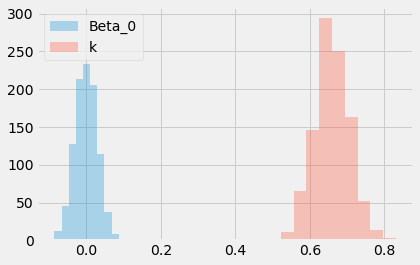

In [30]:
mcSim.plot_parameter_estimates(0,1,1000,0.1,.3)

$3.3.1$ Example

An example is the effect of HRT on coronary heart disease (CHD) in women. Several studies showed that HRT reduced coronary heart disease (CHD), but subsequent RCTs showed that HRT might increase the risk of CHD disease. The Women in the observational studies on HRT were more health conscious, more physically active, and had higher socioeconomic status than those not on HRT. This self-selection of women (selection bias) led to confounding and a “healthy-user bias”.